## Predição de Links em Redes de Coautoria

#### Equipe:
* Julio Sales
* Henrique Lima
* Mácio Matheus
* Victor Outtes

In [77]:
import pandas as pd
import itertools
import networkx as nx
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix
import string
import nltk
nltk.download('punkt')
nltk.download('rslp')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/victorm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /home/victorm/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/victorm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Leitura da base de dados de artigos coletada pelo scrapper

In [2]:
papers = pd.read_json('../datasets/_papers.json', dtype=str)
papers['date_create']=papers['date_create'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
len(papers)

83659

In [3]:
papers.head()

,abstract,area,authors,date_create,idpaper,title
0,"we describe a new algorithm, the $(k,\ell)$-pe...",math.co cs.cg,"['streinu', 'theran']",2007-03-30,0704.0002,sparsity-certifying graph decompositions
1,we show that a determinant of stirling cycle n...,math.co,['callan'],2007-03-30,0704.0004,a determinant of stirling cycle numbers counts...
2,partial cubes are isometric subgraphs of hyper...,math.co,['ovchinnikov'],2007-03-31,0704.0010,"partial cubes: structures, characterizations, ..."
3,in this paper we present an algorithm for comp...,math.nt math.ag,"['cunningham', 'dembele']",2007-03-31,0704.0011,computing genus 2 hilbert-siegel modular forms...
4,"recently, bruinier and ono classified cusp for...",math.nt,['choi'],2007-03-31,0704.0012,distribution of integral fourier coefficients ...


#### Filtrando os registros entre 2007 e 2008 e criando uma base para cada ano (passado e futuro)

In [4]:
papers = papers[(papers['date_create'] >= '2007-01-01') & (papers['date_create'] < '2009-01-01')]

In [5]:
papers_passado = papers[papers['date_create'] <= '2007-12-31']
papers_futuro = papers[papers['date_create'] > '2007-12-31']

In [6]:
len(papers_passado)

11026

In [7]:
len(papers_futuro)

10771

#### Listando apenas os autores únicos de 2007

In [8]:
a_passado = papers_passado['authors'].apply(lambda x: x[1:-1].replace('\'','').replace('\"','')).replace(' ','')
autores_passado = []
for autor in a_passado:
    valores = autor.split(',')
    for v in valores:
        autores_passado.append(v.strip())
autores_passado = list(set(autores_passado))
len(autores_passado)

9630

#### Listando apenas os autores únicos de 2008

In [9]:
a_futuro = papers_futuro['authors'].apply(lambda x: x[1:-1].replace('\'','').replace('\"','')).replace(' ','')
autores_futuro = []
for autor in a_futuro:
    valores = autor.split(',')
    for v in valores:
        autores_futuro.append(v.strip())
autores_futuro = list(set(autores_futuro))
len(autores_futuro)

10017

#### Criando a lista de autores que publicaram nos 2 anos

In [10]:
autores = [a for a in autores_passado if a in autores_futuro]

In [11]:
len(autores)

4788

#### Criando o grafo passado (2007) apenas com os relacionamentos ocorridos em 2007

In [12]:
grafo_passado = nx.Graph()

In [13]:
# para cada autor
for autor in autores:
    # todos os papers do autor
    papers_autor = list(papers_passado[(papers_passado['authors'].str.contains(autor))]['idpaper'])
    grafo_passado.add_node(
        autor,
        texts=papers_autor,
    )

In [14]:
# para cada autor
for autor in autores:
    # todos os coautores dos papers do autor
    coautores = papers_passado[(papers_passado['authors'].str.contains(autor))]['authors']
    if not coautores.empty:
        coautores = coautores.values[0]
        coautores = coautores[1:-1].replace('\'','').replace('\"','').split(',')
        for coautor in coautores:
            coautor = coautor.strip()
            if autor != coautor:
                grafo_passado.add_edge(autor.strip(), coautor.strip())

In [15]:
pos = nx.spring_layout(grafo_passado)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


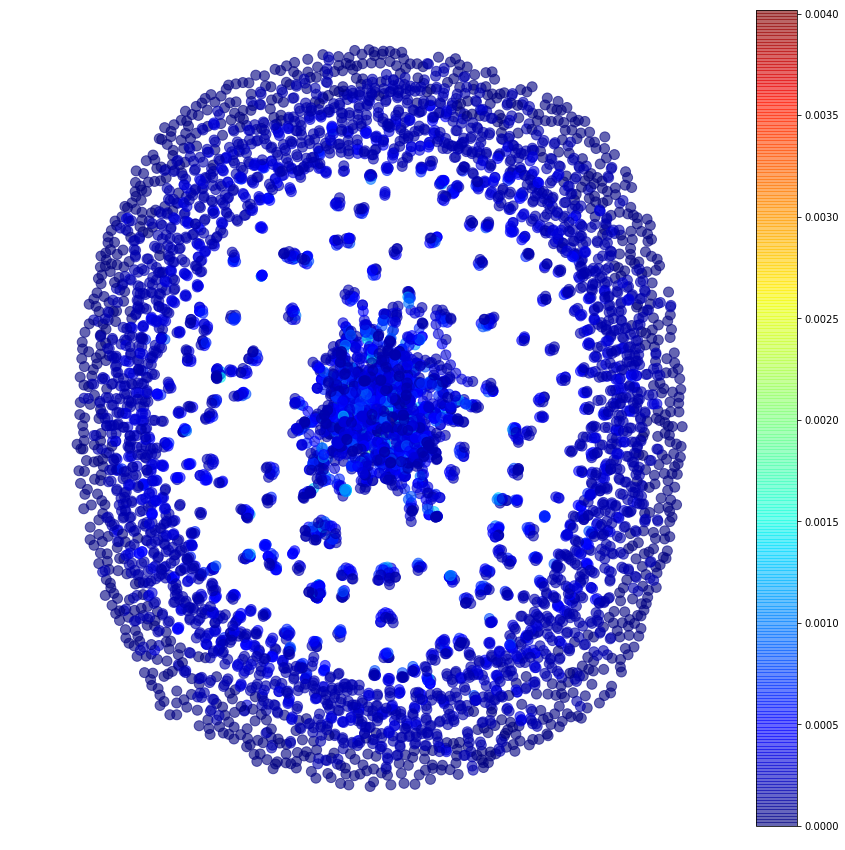

In [16]:
node_color = [cent for cent in nx.degree_centrality(grafo_passado).values()]
node_size = [100 for node in grafo_passado.nodes()]
plt.figure(figsize=(15,15))
ed = nx.draw_networkx_edges(grafo_passado, pos=pos, alpha=0.4, edge_color='black')
no = nx.draw_networkx_nodes(grafo_passado, pos=pos, alpha=0.6, with_labels=False, node_color=node_color, 
                            cmap=cm.jet, vmin=min(list(nx.degree_centrality(grafo_passado).values())), 
                            vmax=max(list(nx.degree_centrality(grafo_passado).values())),
                            node_size=node_size)
plt.colorbar(no)
plt.axis('off')
plt.show()

#### Criando o grafo futuro (2008) apenas com os relacionamentos ocorridos em 2008

In [17]:
grafo_futuro = nx.Graph()

In [18]:
# para cada autor
for autor in autores:
    # todos os papers do autor
    papers_autor = list(papers_futuro[(papers_futuro['authors'].str.contains(autor))]['idpaper'])
    grafo_futuro.add_node(
        autor,
        texts=papers_autor,
    )

In [19]:
# para cada autor
for autor in autores:
    # todos os coautores dos papers do autor
    coautores = papers_futuro[(papers_futuro['authors'].str.contains(autor))]['authors']
    if not coautores.empty:
        coautores = coautores.values[0]
        coautores = coautores[1:-1].replace('\'','').replace('\"','').split(',')
        for coautor in coautores:
            coautor = coautor.strip()
            if autor != coautor:
                grafo_futuro.add_edge(autor.strip(), coautor.strip())

In [20]:
pos = nx.spring_layout(grafo_futuro)

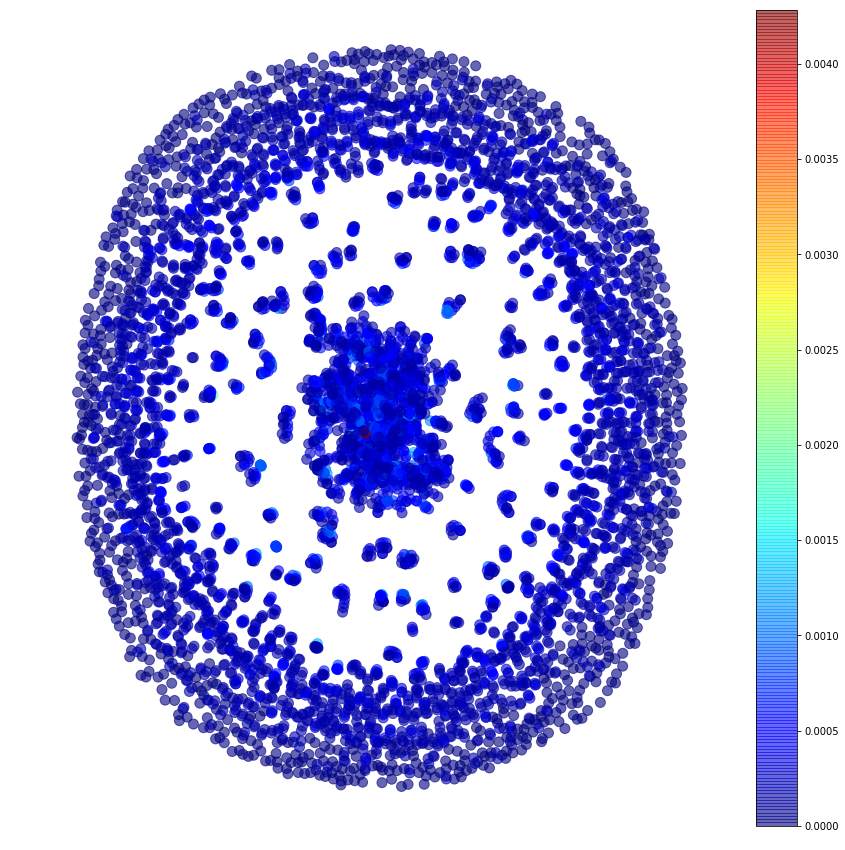

In [21]:
node_color = [cent for cent in nx.degree_centrality(grafo_futuro).values()]
node_size = [100 for node in grafo_futuro.nodes()]
plt.figure(figsize=(15,15))
ed = nx.draw_networkx_edges(grafo_futuro, pos=pos, alpha=0.4, edge_color='black')
no = nx.draw_networkx_nodes(grafo_futuro, pos=pos, alpha=0.6, with_labels=False, node_color=node_color, 
                            cmap=cm.jet, vmin=min(list(nx.degree_centrality(grafo_futuro).values())), 
                            vmax=max(list(nx.degree_centrality(grafo_futuro).values())),
                            node_size=node_size)
plt.colorbar(no)
plt.axis('off')
plt.show()

#### Capturando os pares de autores em 2007 com distância 2 entre si

In [22]:
length = nx.all_pairs_shortest_path_length(grafo_passado)
distancias = [x for x in length]
authors_dist_2 = []
for a in distancias:
    p = a[0]
    c = a[1]
    for co,va in c.items():
        if va == 2:
            authors_dist_2.append([p, co])
print(authors_dist_2[:10])

[['cooper', 'schleimer'], ['cooper', 'galatius'], ['révész', 'uribe'], ['révész', 'guillemin'], ['révész', 'bloom'], ['révész', 'maubach'], ['révész', 'peters'], ['révész', 'szyszkowicz'], ['mccoy', 'assani'], ['mccoy', 'jafari']]


#### Criando um dataframe com os pares com distância 2 em 2007

In [23]:
ligacoes_futuras = pd.DataFrame(authors_dist_2, columns=['Author_1', 'Author_2'])
ligacoes_futuras.head()

,Author_1,Author_2
0,cooper,schleimer
1,cooper,galatius
2,révész,uribe
3,révész,guillemin
4,révész,bloom


#### Adicionando uma coluna informando se os pares de autores que não se relacionavam em 2007 passaram a se relacionar em 2008

In [24]:
ligacoes_futuras['label'] = ligacoes_futuras.apply(
    lambda lig: grafo_futuro.has_edge(lig['Author_1'], lig['Author_2']) or 
    grafo_futuro.has_edge(lig['Author_2'], lig['Author_1']), axis=1)

#### Mostrando que existiram 166 trabalhos em conjunto em 2008 que não existiram em 2007!

In [25]:
len(ligacoes_futuras[ligacoes_futuras['label'] == True])

166

#### São 12.674 possibilidades de trabalho em conjunto

In [26]:
len(ligacoes_futuras)

12674

#### Salvando/lendo a base construida até então para facilitar (save point)

In [18]:
#ligacoes_futuras.to_csv('ligacoes_futuras_dist_2.csv', index=False)
ligacoes_futuras = pd.read_csv('../datasets/ligacoes_futuras_dist_2.csv', dtype={'Author_1': str, 'Author_2': str, 'label': bool})

#### Função para concatenar os textos dos artigos cujos IDs forem passados como uma lista

In [4]:
def papers_from_idlist(list_papers):
    p = papers_passado[papers_passado['idpaper'].isin(list_papers)][['title', 'abstract']].drop_duplicates()
    p['joined'] = p['title'].str.cat(p['abstract'], sep=' ')
    return ' '.join(list(p['joined']))

#### Aqui montamos um dataframe servindo de banco de dados para os textos dos artigos para cada autor. Para economizar processamento!

In [34]:
base_author = pd.DataFrame()
base_author['author'] = pd.concat([ligacoes_futuras['Author_1'], ligacoes_futuras['Author_2']]).drop_duplicates()
base_author['texts'] = base_author['author'].apply(
    lambda x: papers_from_idlist(grafo_passado.node[x]['texts']) if bool(grafo_passado.node[x]) else None)
base_author.head()

,author,texts
0,cooper,the thurston norm via normal surfaces given a ...
2,révész,monge-amp\`ere measures for convex bodies and ...
8,mccoy,fuchs versus painlev\'e we briefly recall the ...
17,pruidze,motion planning in tori let x be a subcomplex ...
22,proutiere,a particle system in interaction with a rapidl...


In [48]:
base_author = base_author[~base_author['texts'].isnull()]

#### Salvando a base de dados de textos de autores (demora muito a ser criada!)

In [28]:
#base_author.to_csv('base_author.csv', index=False)
base_author = pd.read_csv('base_author.csv', dtype=str, keep_default_na=False)

#### Sequência de funções para calcular Jaccard!
#### Calcula a intersecção entre 2 listas

In [29]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

#### Calcula a união entre 2 listas

In [30]:
def union(lst1, lst2): 
    return list(set(lst1) | set(lst2))

#### Tira as stopwords, obtem os radicais e gera uma lista de tokens (radicais) dos textos dos 2 autores e calcula Jaccard!

In [61]:
def jaccard(text_a, text_b):
    stopwords = set(nltk.corpus.stopwords.words('english') + list(string.punctuation))
    stemmer = nltk.stem.RSLPStemmer()
    text_a_tokens = nltk.word_tokenize(text_a)
    text_b_tokens = nltk.word_tokenize(text_b)
    text_a_tokens_stem = [stemmer.stem(p) for p in text_a_tokens if p not in stopwords]
    text_b_tokens_stem = [stemmer.stem(p) for p in text_b_tokens if p not in stopwords]
    inter = intersection(text_a_tokens_stem, text_b_tokens_stem)
    uni = union(text_a_tokens_stem, text_b_tokens_stem)
    return len(inter)/len(uni)

In [62]:
def calculo_jaccard(dupla):
    if base_author[base_author['author']==dupla['Author_1']].empty or base_author[base_author['author']==dupla['Author_2']].empty:
        return 0
    texto_a = base_author[base_author['author']==dupla['Author_1']]['texts'].values[0]
    texto_b = base_author[base_author['author']==dupla['Author_2']]['texts'].values[0]
    return jaccard(texto_a, texto_b)

#### Cria uma coluna nova no dataframe dos autores adicionando o valor de Jaccard

In [65]:
ligacoes_futuras['jaccard'] = ligacoes_futuras.apply(calculo_jaccard, axis=1)

#### Checa os valores de Jaccard para os casos onde os autores de distância 2 em 2007 tiveram trabalho juntos em 2008!

In [66]:
ligacoes_futuras[ligacoes_futuras['label']==True].head()

,Author_1,Author_2,label,jaccard
240,kassabov,guralnick,True,0.308176
241,kassabov,lubotzky,True,0.407407
268,promislow,bayraktar,True,0.041667
288,tran,herau,True,0.046774
354,marquez-carreras,tindel,True,0.043478


#### Checa os valores de Jaccard para os casos onde os autores de distância 2 em 2007 NÃO tiveram trabalho juntos em 2008!

In [72]:
ligacoes_futuras[ligacoes_futuras['label']==False].head(30)

,Author_1,Author_2,label,jaccard
0,cooper,schleimer,False,0.041379
1,cooper,galatius,False,0.021898
2,révész,uribe,False,0.064081
3,révész,guillemin,False,0.064912
4,révész,bloom,False,0.064639
5,révész,maubach,False,0.062185
6,révész,peters,False,0.121457
7,révész,szyszkowicz,False,0.046382
8,mccoy,assani,False,0.378016
9,mccoy,jafari,False,0.082278


In [68]:
#ligacoes_futuras.to_csv('resultado_previsao_jaccard.csv', index=False)

In [71]:
ligacoes_futuras[ligacoes_futuras['label']== True].head(30)

,Author_1,Author_2,label,jaccard
240,kassabov,guralnick,True,0.308176
241,kassabov,lubotzky,True,0.407407
268,promislow,bayraktar,True,0.041667
288,tran,herau,True,0.046774
354,marquez-carreras,tindel,True,0.043478
437,cordero-soto,lopez,True,0.094188
441,de leo,marrero,True,0.093645
505,toninelli,giacomin,True,0.276109
511,divaani-aazar,tousi,True,0.284615
645,dinh,nguyen,True,0.169284


#### Aplicando um threshold de 0.095 para prever a coautoria futura

In [73]:
ligacoes_futuras['previsao'] = ligacoes_futuras['jaccard'] > 0.095

#### Mostrando a tabela final que foi criada! LABEL tem os valores reais e PREVISAO tem os valores previstos com o threshold!

In [74]:
ligacoes_futuras[ligacoes_futuras['label']== True].head(30)

,Author_1,Author_2,label,jaccard,previsao
240,kassabov,guralnick,True,0.308176,True
241,kassabov,lubotzky,True,0.407407,True
268,promislow,bayraktar,True,0.041667,False
288,tran,herau,True,0.046774,False
354,marquez-carreras,tindel,True,0.043478,False
437,cordero-soto,lopez,True,0.094188,False
441,de leo,marrero,True,0.093645,False
505,toninelli,giacomin,True,0.276109,True
511,divaani-aazar,tousi,True,0.284615,True
645,dinh,nguyen,True,0.169284,True


In [75]:
ligacoes_futuras[ligacoes_futuras['label']== False].head(30)

,Author_1,Author_2,label,jaccard,previsao
0,cooper,schleimer,False,0.041379,False
1,cooper,galatius,False,0.021898,False
2,révész,uribe,False,0.064081,False
3,révész,guillemin,False,0.064912,False
4,révész,bloom,False,0.064639,False
5,révész,maubach,False,0.062185,False
6,révész,peters,False,0.121457,True
7,révész,szyszkowicz,False,0.046382,False
8,mccoy,assani,False,0.378016,True
9,mccoy,jafari,False,0.082278,False


#### Calcula a matriz de confusão

In [79]:
real = list(ligacoes_futuras['label'])
previsto = list(ligacoes_futuras['previsao'])

In [80]:
matrix = confusion_matrix(real, previsto)

In [81]:
matrix

array([[11010,  1498],
       [   58,   108]])

#### A partir da matriz de confusão obtemos os valores de TN, FP, FN e TP
* True Negative
* False Positive
* False Negative
* True Positive

In [82]:
tn, fp, fn, tp = matrix.ravel()

In [83]:
(tn, fp, fn, tp)

(11010, 1498, 58, 108)

#### Cálculo da acurácia geral da previsão: 87,72% de acerto!

In [85]:
accuracy = (tn + tp)/(tn + fp + fn + tp)
accuracy

0.8772289727000158